In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("Sample_Madrid.csv")
df

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,El Viso,Entire home/apt,73,5,5,2019-06-16,0.70,1,3,Madrid
1,Universidad,Private room,30,1,26,2019-09-13,9.63,13,228,Madrid
2,Puerta del Angel,Entire home/apt,100,3,20,2019-09-09,3.64,10,89,Madrid
3,Puerta del Angel,Entire home/apt,65,1,8,2019-09-08,2.89,1,167,Madrid
4,Sol,Entire home/apt,180,2,4,2019-06-30,1.03,1,2,Madrid
...,...,...,...,...,...,...,...,...,...,...
4065,Justicia,Shared room,16,1,156,2019-09-02,4.80,8,73,Madrid
4066,Jerónimos,Entire home/apt,90,3,5,2018-11-28,0.11,2,343,Madrid
4067,Palacio,Entire home/apt,70,1,88,2019-09-01,3.07,1,160,Madrid
4068,Palacio,Entire home/apt,110,1,27,2019-09-02,3.06,4,146,Madrid


In [3]:
df = df.drop(columns=['neighbourhood'])
df = df.drop(columns=['city'])
df = df.drop(columns=['last_review'])

In [4]:
df.price=np.log(df.price)

In [5]:
df_private = df.loc[df.room_type == "Private room"]
df_private = df_private.drop(columns=['room_type'])

In [6]:
df_private.shape

(1475, 6)

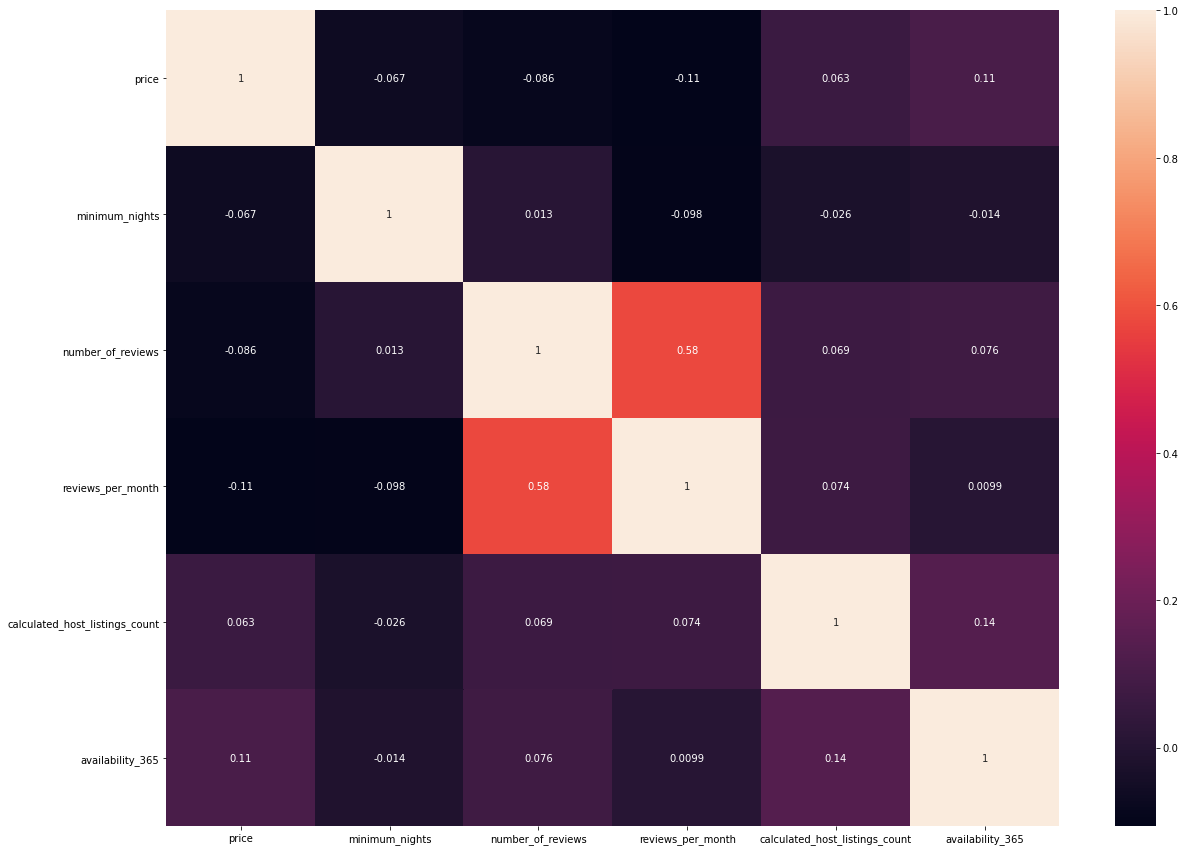

In [7]:
corrmat = df_private[df_private._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [8]:
#Private
train, test = train_test_split(df_private, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [9]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['availability_365']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['availability_365']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Availability 365 (Training set) Madrid')
    plt.xlabel('Availability 365')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['availability_365']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['availability_365']], np.exp(y_pred), 'bo')
    plt.title('Price vs Availability 365 (Test set) Madrid')
    plt.xlabel('Availability 365')
    plt.ylabel('Price')
    plt.show()


In [10]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([-0.02960727, -0.00049042, -0.03153399,  0.00441806,  0.0003729 ]),
 3.5189632073544104)

In [11]:
mr_y_pred = mr.predict(X_test)
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,413.46,20.33,0.03
Test,444.11,21.07,0.02


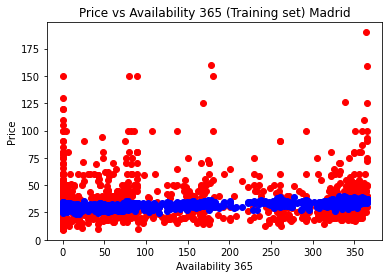

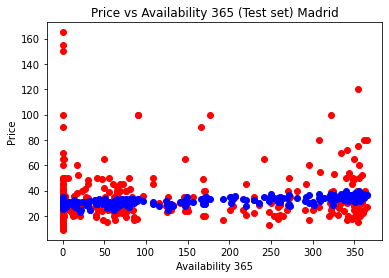

In [12]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

In [13]:
X = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     8.288
Date:                Tue, 09 Feb 2021   Prob (F-statistic):           1.04e-07
Time:                        21:25:26   Log-Likelihood:                -740.01
No. Observations:                1180   AIC:                             1492.
Df Residuals:                    1174   BIC:                             1522.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              3.5190      0.035    101.045      0.000       3.451       3.587
minimum_nights                    -0.0296      0.014     -2.145      0.032      -0.057      -0.003
number_of_reviews                 -0.0005      0.000     -1.163      0.245      -0.001       0.000
reviews_per_month                 -0.0315      0.010     -3.159      0.002      -0.051      -0.012
calculated_host_listings_count     0.0044      0.004      1.023      0.307      -0.004       0.013
availability_365                   0.0004   9.85e-05      3.787      0.000       0.000       0.001
==============================================================================
Omnibus:                       48.341   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.952
Skew:                           0.472   Prob(JB):                     1.17e-12
Kurtosis:                       3.477   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
X_train_opt = X_train.drop(columns=["number_of_reviews", "calculated_host_listings_count"])
X_test_opt = X_test.drop(columns=["number_of_reviews", "calculated_host_listings_count"])
X_train_opt

,minimum_nights,reviews_per_month,availability_365
3855,1,2.59,44
103,2,0.23,0
771,2,1.19,337
2606,2,1.04,310
3275,2,1.00,48
...,...,...,...
2106,2,2.35,349
2300,6,0.25,271
3353,1,0.90,0
1515,2,0.54,0


In [34]:
mr = LinearRegression().fit(X_train_opt, y_train)
mr.coef_, mr.intercept_

(array([-0.03076843, -0.03765229,  0.00037463]), 3.5277852065715005)

In [35]:
mr_y_pred = mr.predict(X_test_opt)
metrics(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,414.21,20.35,0.03
Test,447.73,21.16,0.01


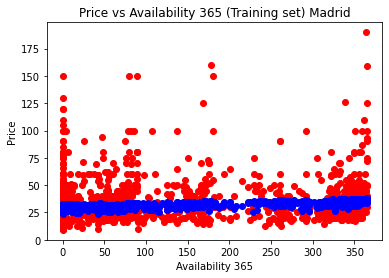

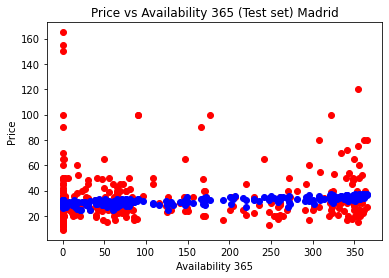

In [36]:
visualising(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr)

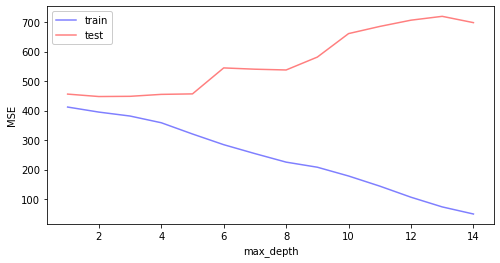

In [18]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [19]:
dt = DecisionTreeRegressor(max_depth = 2, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)

,MSE,RMSE,R2
Train,394.72,19.87,0.06
Test,447.44,21.15,0.01


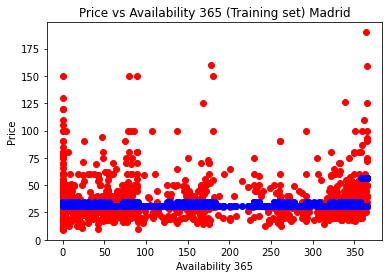

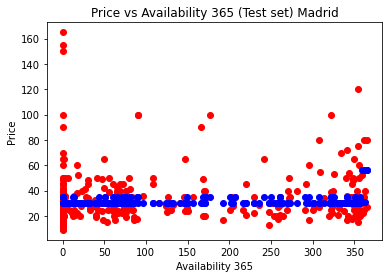

In [20]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance. Washington D.C.')

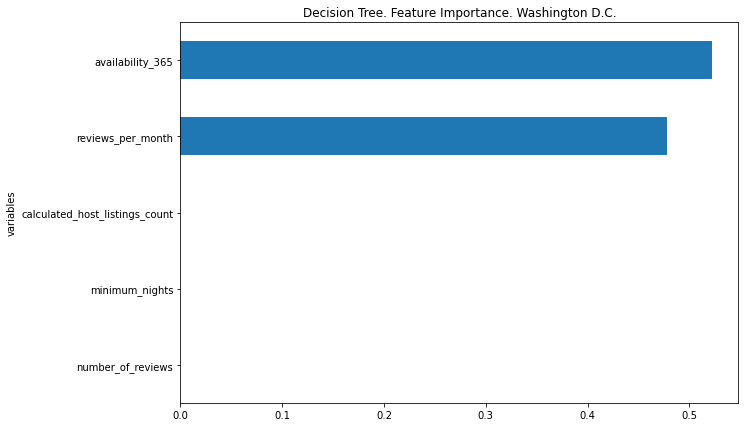

In [21]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'variables': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance. Washington D.C.')

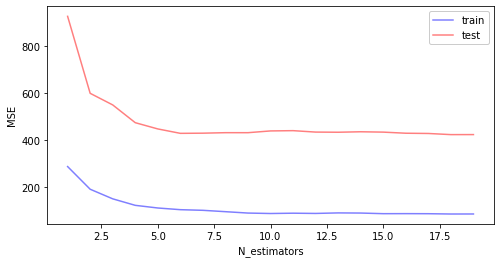

In [22]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

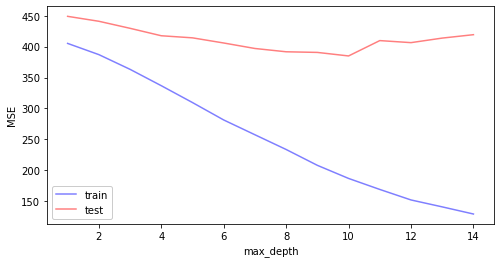

In [23]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=6, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [24]:
rf = RandomForestRegressor(n_estimators = 6, max_depth = 4, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)

,MSE,RMSE,R2
Train,336.86,18.35,0.17
Test,417.69,20.44,0.08


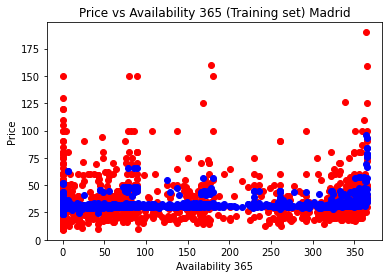

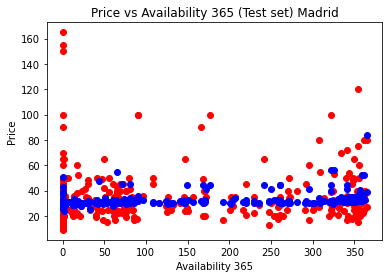

In [25]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

<AxesSubplot:ylabel='variables'>

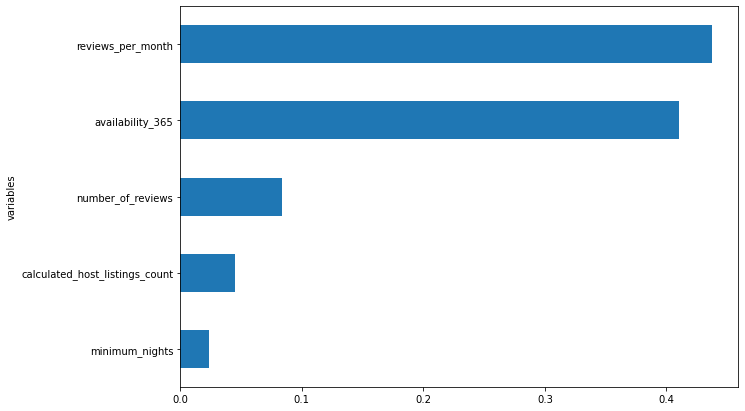

In [26]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'variables': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
#plt.title('Random Forest. Feature Importance. Washington D.C.')

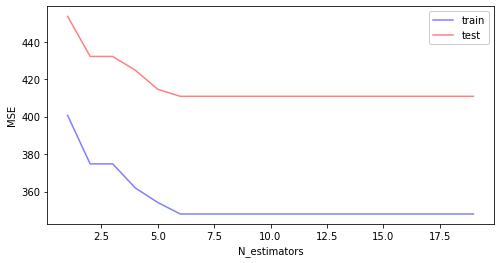

In [27]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

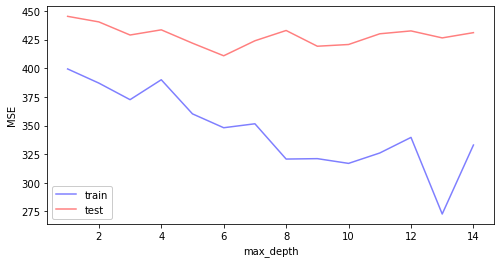

In [28]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=6, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [29]:
catboost = CatBoostRegressor(iterations=6, max_depth=6, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,348.08,18.66,0.19
Test,410.90,20.27,0.08


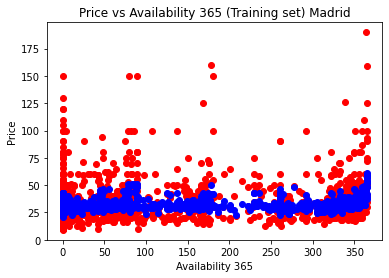

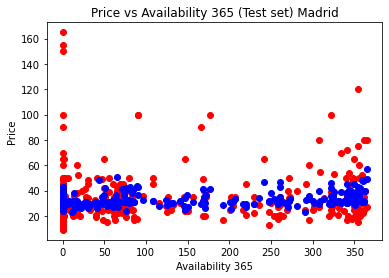

In [30]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance. Washington D.C.')

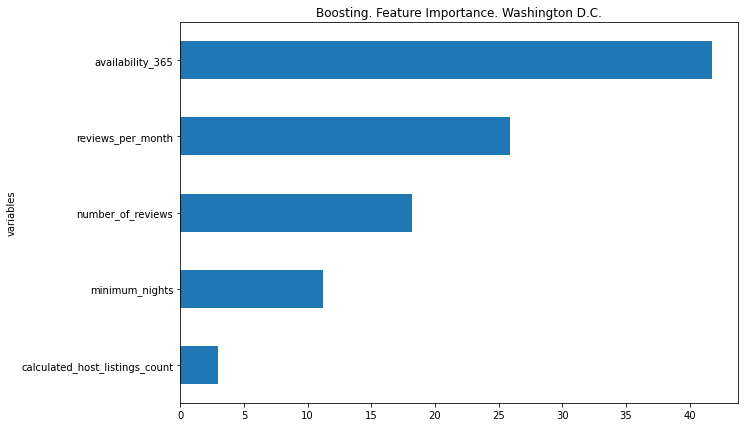

In [31]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'variables': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance. Washington D.C.')